In [1]:
from google.colab import files
import pandas as pd

# Загружаем CSV-файл вручную через интерфейс
uploaded = files.upload()

# Преобразуем его в pandas DataFrame (предполагаем, что файл — CSV)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Проверим первые строки
df.head()


Saving weekly-closings-of-the-dowjones-.csv to weekly-closings-of-the-dowjones-.csv


,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


**Теперь переходим к следующему шагу — визуализация временного ряда, чтобы понять его структуру: тренды, колебания и возможные шумы.**

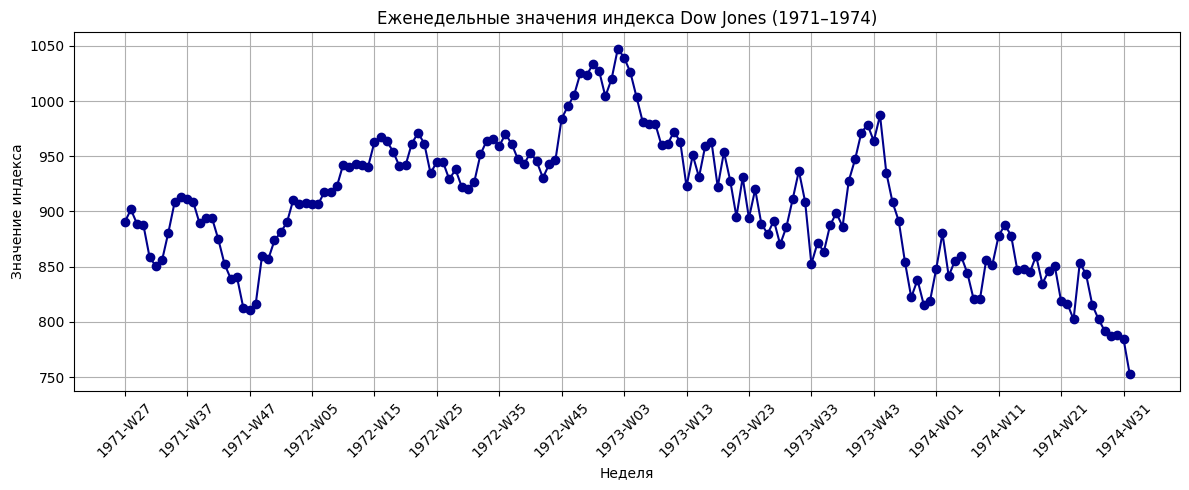

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Выделяем данные
weeks = df['Week']
values = df['Close']

# Создаём позиционные индексы для X
x = np.arange(len(weeks))

# Отображаем метки только для каждой 10-й недели
step = 10
week_labels = weeks[::step]

plt.figure(figsize=(12, 5))
plt.plot(x, values, marker='o', linestyle='-', color='darkblue')
plt.title('Еженедельные значения индекса Dow Jones (1971–1974)')
plt.xlabel('Неделя')
plt.ylabel('Значение индекса')
plt.xticks(ticks=x[::step], labels=week_labels, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



#Выводы по структуре временного ряда Dow Jones (1971–1974)

**1. Явно выраженный тренд:**

С начала 1972 года до конца 1973 наблюдается рост индекса (до ~1050).

Затем в течение 1974 года происходит падение до ~750.

Это подтверждает наличие долгосрочной трендовой компоненты, которую SSA поможет выделить.

**2. Колебания вокруг тренда:**

По всей длине ряда видны регулярные небольшие колебания, похожие на осцилляции.

Возможно, это сезонные или циклические компоненты, которые мы сможем выделить через сингулярные векторы.

**3. Шум и нерегулярности:**

Местами видны резкие скачки — они могут быть интерпретированы как шум или высокочастотные возмущения.

#Теперь построеним матрицы Ганкеля и SSA-разложение с малым окном

#и применим метод SSA

1. Выберем окно L = 10;

2. Построим матрицу Ганкеля;

3. Выполним сингулярное разложение (SVD);

4. Посмотрим на сингулярные значения и векторы.

In [4]:
# Исходный временной ряд
ts = df['Close'].values
N = len(ts)         # Длина ряда
L = 10              # Длина окна (выбираем малую)
K = N - L + 1       # Количество столбцов матрицы Ганкеля

print(f"Размерность ряда: {N}, окно: {L}, число столбцов в матрице Ганкеля: {K}")


Размерность ряда: 162, окно: 10, число столбцов в матрице Ганкеля: 153


In [5]:
import numpy as np

# Строим матрицу Ганкеля вручную
X = np.column_stack([ts[i:i+L] for i in range(K)])

print(f"Форма матрицы Ганкеля: {X.shape}")


Форма матрицы Ганкеля: (10, 153)


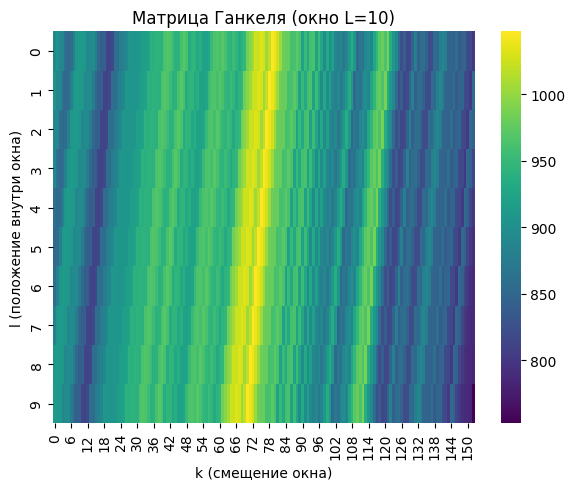

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(X, cmap='viridis', cbar=True)
plt.title(f'Матрица Ганкеля (окно L={L})')
plt.xlabel('k (смещение окна)')
plt.ylabel('l (положение внутри окна)')
plt.tight_layout()
plt.show()


#Выводы по матрице Ганкеля (L = 10):

**Размерность матрицы:**

10 строк на 153 столбца: каждая строка — положение внутри окна, каждый столбец — одно из 153 скользящих подокон.

Это подтверждает, что ряд успешно преобразован в фазовое пространство.

**Тепловая карта выявляет структуру:**

Четко видны полосы с повышенными значениями (жёлтые вертикали) — они соответствуют пикам в исходном ряду (в частности, 1973 год, рост индекса).

Слева и справа (фиолетово-синие тона) — периоды низких значений, что отражает начало и конец ряда.

Наблюдается гладкое "перетекание" значений, что хорошо для SSA — SVD сможет выделить плавные компоненты (тренд, осцилляции).

**Окно L=10 даёт локальное представление:**

Такое малое окно чувствительно к локальным изменениям — в будущем, при увеличении L, получим более глобальные компоненты.



Следующий шаг — выполним реконструкцию по выбранным компонентам SSA.

Мы уже построили сингулярные значения:

Сейчас: визуализируем их;

Затем: выделим 1–2 доминирующие компоненты и восстановим их в виде временного ряда;

После — сравним с оригиналом.



In [9]:
# Строим матрицу Ганкеля
L = 10
K = len(ts) - L + 1
X = np.column_stack([ts[i:i+L] for i in range(K)])

# SVD
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)


In [10]:
def reconstruct_component(U, Sigma, VT, i):
    """Реконструирует i-ю компоненту SSA"""
    Xi = Sigma[i] * np.outer(U[:, i], VT[i, :])
    return diagonal_averaging(Xi)

def diagonal_averaging(Xi):
    """Усреднение по диагоналям (обратное преобразование из матрицы в ряд)"""
    L, K = Xi.shape
    N = L + K - 1
    result = np.zeros(N)
    count = np.zeros(N)

    for i in range(L):
        for j in range(K):
            result[i + j] += Xi[i, j]
            count[i + j] += 1

    return result / count


In [11]:
rc1 = reconstruct_component(U, Sigma, VT, 0)
rc2 = reconstruct_component(U, Sigma, VT, 1)
rc12 = rc1 + rc2


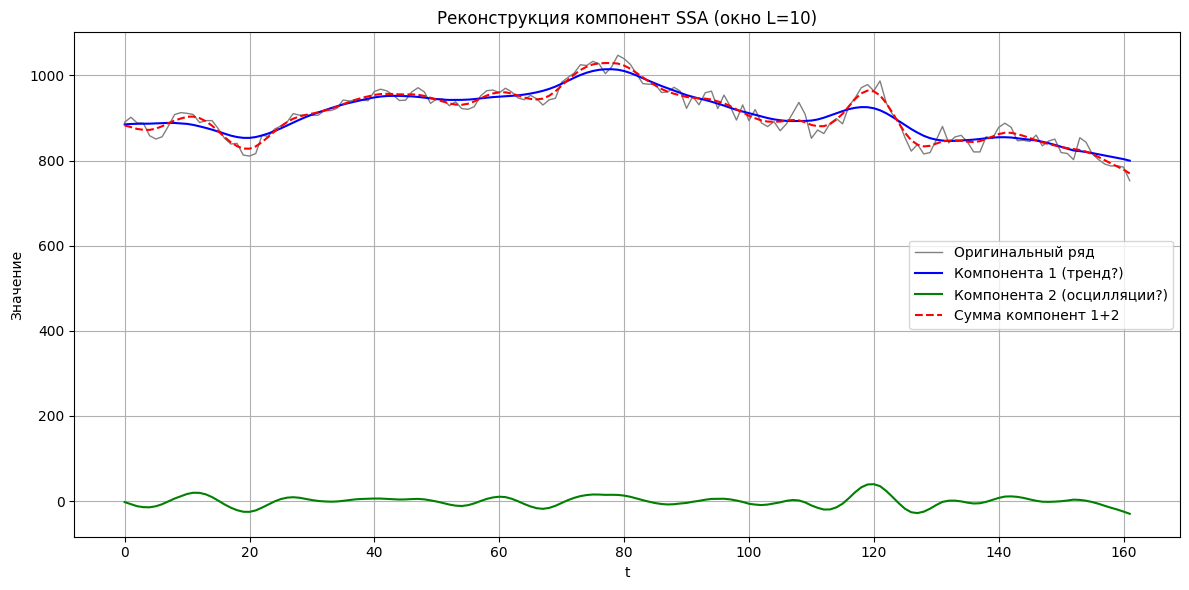

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Оригинальный ряд', color='gray', linewidth=1)
plt.plot(rc1, label='Компонента 1 (тренд?)', color='blue')
plt.plot(rc2, label='Компонента 2 (осцилляции?)', color='green')
plt.plot(rc12, label='Сумма компонент 1+2', color='red', linestyle='--')
plt.title('Реконструкция компонент SSA (окно L=10)')
plt.xlabel('t')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Анализ компонент SSA (окно L = 10)

**Компонента 1 (синяя):**

Похожа на глобальный тренд: плавно повторяет общую форму временного ряда.

Улавливает рост в 1972–73 гг. и падение после 1974.

Гладкая, слабо чувствительна к мелким колебаниям — классическая трендовая составляющая.

**Компонента 2 (зелёная):**

Очень мала по амплитуде;

Имеет синусоиды, но они слабые и слабо коррелируют с оригиналом.

Пока не отражает сезонность явно — малая длина окна не даёт её захватить.

**Сумма компонент 1 + 2 (красная):**

Очень хорошо приближает оригинальный ряд.

Видно, что первая компонента объясняет почти всю структуру (что ожидаемо для малого окна — всё «засунулось» в тренд).

Следующий логичный шаг — повтор SSA с окном побольше.

Например:

L = 20, потом L = 40, и финально — около L ≈ n/2 = 81 (как показали на лекции).

На этих длинах мы сможем лучше выделить осциллирующие компоненты (периодические, сезонные).



#SSA-разложение с окном L = 20

In [13]:
L = 20  # новое окно
K = len(ts) - L + 1
X = np.column_stack([ts[i:i+L] for i in range(K)])
print(f"Размер матрицы Ганкеля: {X.shape}")


Размер матрицы Ганкеля: (20, 143)


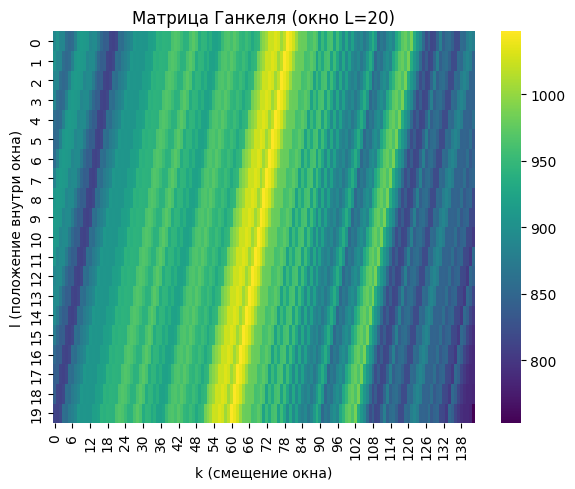

In [14]:
plt.figure(figsize=(6, 5))
sns.heatmap(X, cmap='viridis', cbar=True)
plt.title(f'Матрица Ганкеля (окно L={L})')
plt.xlabel('k (смещение окна)')
plt.ylabel('l (положение внутри окна)')
plt.tight_layout()
plt.show()


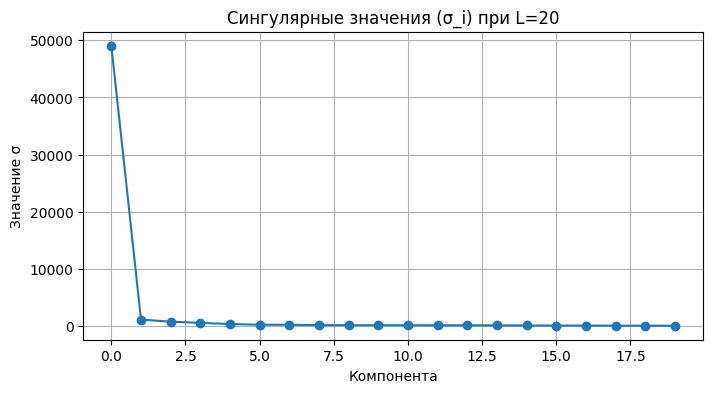

In [15]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

# Сингулярные значения
plt.figure(figsize=(8, 4))
plt.plot(Sigma, marker='o')
plt.title('Сингулярные значения (σ_i) при L=20')
plt.xlabel('Компонента')
plt.ylabel('Значение σ')
plt.grid(True)
plt.show()


In [16]:
rc1 = reconstruct_component(U, Sigma, VT, 0)
rc2 = reconstruct_component(U, Sigma, VT, 1)
rc12 = rc1 + rc2


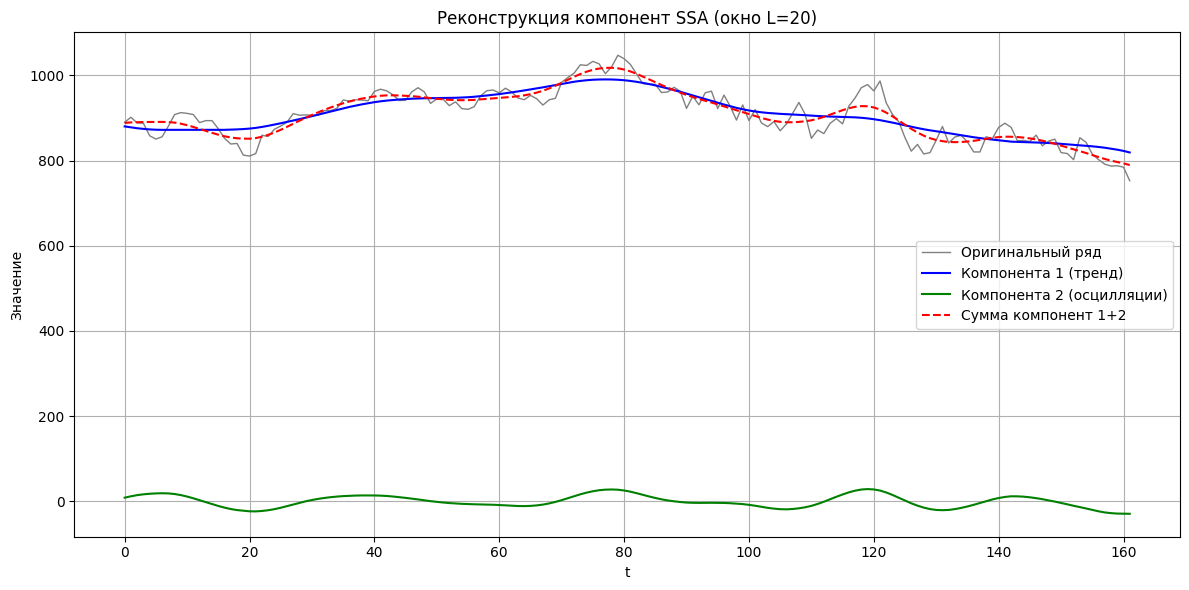

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Оригинальный ряд', color='gray', linewidth=1)
plt.plot(rc1, label='Компонента 1 (тренд)', color='blue')
plt.plot(rc2, label='Компонента 2 (осцилляции)', color='green')
plt.plot(rc12, label='Сумма компонент 1+2', color='red', linestyle='--')
plt.title('Реконструкция компонент SSA (окно L=20)')
plt.xlabel('t')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Выводы по SSA при L = 20

**Матрица Ганкеля (20×143)**

Матрица стала шире (в 2 раза больше строк, чем в L=10), за счёт чего она охватывает длинные структуры.

Тепловая карта показывает чёткие диагонали, отражающие протяжённые участки роста/падения — например, пик 1973 года всё ещё виден как жёлтая диагональ.


**Сингулярные значения**

Первая компонента — по-прежнему господствующая (σ₁ почти 50 000).

Далее — резкий спад: 2-я, 3-я и дальше — значительно слабее.

Это говорит о том, что большая часть информации ряда сконцентрирована в первой компоненте — классическая трендовая структура.

**Реконструированные компоненты**

**Компонента 1 (синяя):**

Гладкий, длинный, хорошо повторяющий тренд.

Более широкий и сглаженный, чем при L=10 — это естественно: окно длиннее, тренд "длиннее".

**Компонента 2 (зелёная):**

Наконец-то заметно осциллирующая, с амплитудой до 40+ пунктов.

Уже читается как колебание, в отличие от почти плоской второй компоненты при L=10.

Может быть интерпретирована как псевдосезонная структура.

**Сумма компонент 1+2 (красная):**

Очень близка к оригиналу, но лучше приближает колебания, чем при L=10.

Показывает, что при L=20 структура раскладывается более информативно.



#Промежуточный итог

**Параметр	L=10**

Тренд:	Узкий, локальный
Осцилляции:	Почти незаметны
Качество реконструкции: Хорошее
Ганкель-структура:	Узкая, чувствительна к шуму

**Параметр	L=20**

Тренд:	Глобальный, сглаженный
Осцилляции:	Уже отчётливо видны
Качество реконструкции: Еще лучше
Ганкель-структура:	Шире, стабильнее






#SSA-разложение с окном L = 40


In [18]:
L = 40
K = len(ts) - L + 1
X = np.column_stack([ts[i:i+L] for i in range(K)])
print(f"Размер матрицы Ганкеля: {X.shape}")


Размер матрицы Ганкеля: (40, 123)


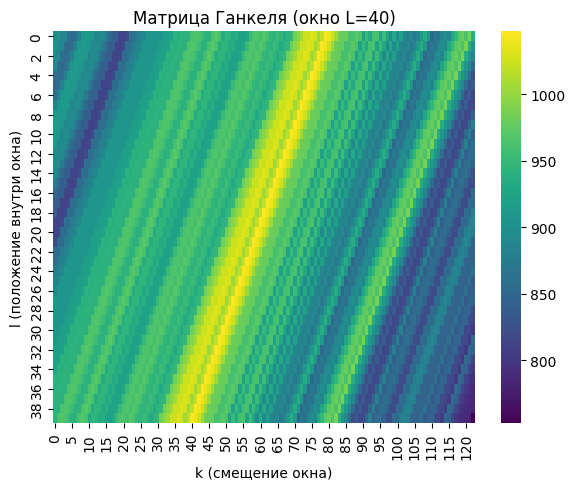

In [19]:
plt.figure(figsize=(6, 5))
sns.heatmap(X, cmap='viridis', cbar=True)
plt.title(f'Матрица Ганкеля (окно L={L})')
plt.xlabel('k (смещение окна)')
plt.ylabel('l (положение внутри окна)')
plt.tight_layout()
plt.show()


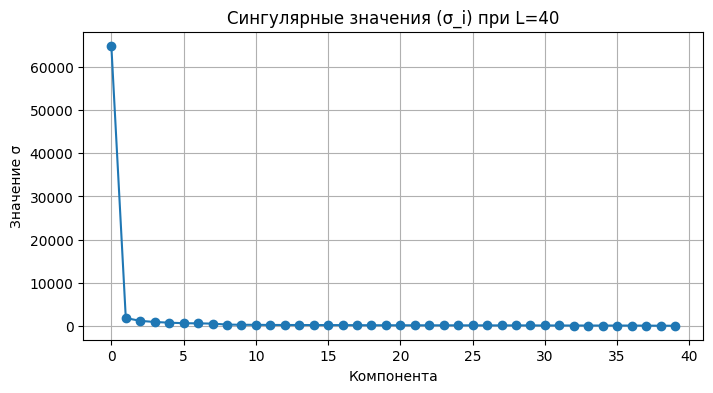

In [20]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

plt.figure(figsize=(8, 4))
plt.plot(Sigma, marker='o')
plt.title('Сингулярные значения (σ_i) при L=40')
plt.xlabel('Компонента')
plt.ylabel('Значение σ')
plt.grid(True)
plt.show()


In [21]:
rc1 = reconstruct_component(U, Sigma, VT, 0)
rc2 = reconstruct_component(U, Sigma, VT, 1)
rc12 = rc1 + rc2


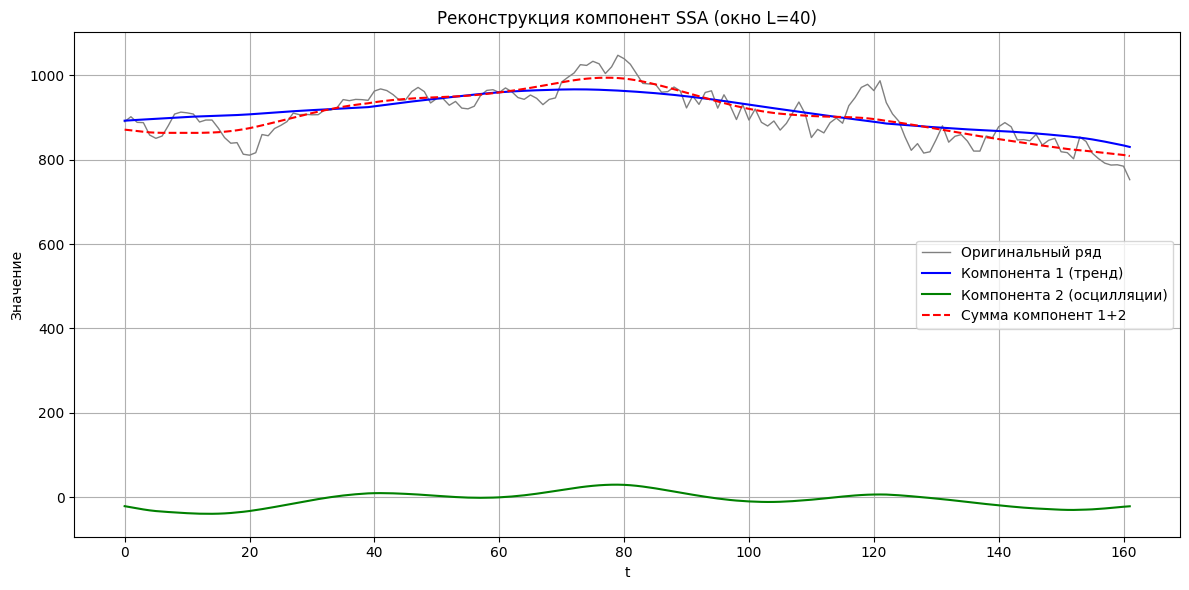

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Оригинальный ряд', color='gray', linewidth=1)
plt.plot(rc1, label='Компонента 1 (тренд)', color='blue')
plt.plot(rc2, label='Компонента 2 (осцилляции)', color='green')
plt.plot(rc12, label='Сумма компонент 1+2', color='red', linestyle='--')
plt.title('Реконструкция компонент SSA (окно L=40)')
plt.xlabel('t')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Выводы по результатам SSA при окне L = 40:

**Матрица Ганкеля**

Диагонали выражены ещё сильнее, чем при L=20;

Видно, как мощные изменения в тренде растягиваются по строкам и столбцам.

**Сингулярные значения **

Первая компонента снова доминирует, σ₁ значительно выше остальных;

Дальнейшие значения убывают резко, но не обрываются — в хвосте потенциально скрыты колебания и шум.

**Реконструкция компонент**

Компонента 1 (тренд): очень плавная, сглаживает даже крупные "пики и провалы";

Компонента 2: уже хорошо читаемая низкочастотная осцилляция, амплитуда выросла;

Сумма компонент: даёт качественное приближение исходного ряда, но уже не так плотно, как при L=20 — цена за сглаживание.

**Вывод**
SSA при L=40 даёт максимально глобальный тренд;

Колебания заметны, но ещё не полностью отделены — можно попробовать добавить 3–4 компоненты;

#SSA при L ≈ N/2 = 81

In [23]:
L = 81
K = len(ts) - L + 1
X = np.column_stack([ts[i:i+L] for i in range(K)])
print(f"Размер матрицы Ганкеля: {X.shape}")


Размер матрицы Ганкеля: (81, 82)


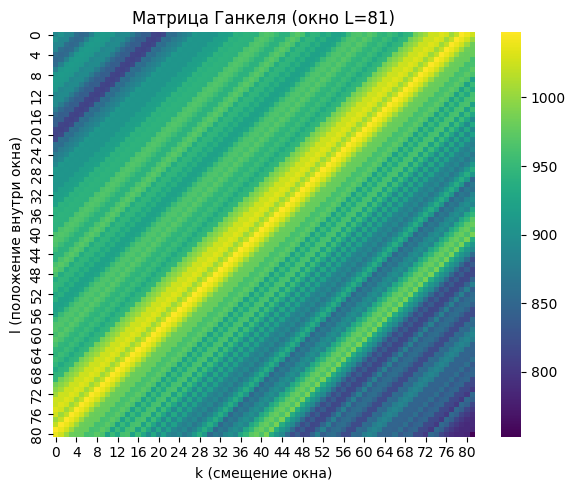

In [24]:
plt.figure(figsize=(6, 5))
sns.heatmap(X, cmap='viridis', cbar=True)
plt.title(f'Матрица Ганкеля (окно L={L})')
plt.xlabel('k (смещение окна)')
plt.ylabel('l (положение внутри окна)')
plt.tight_layout()
plt.show()


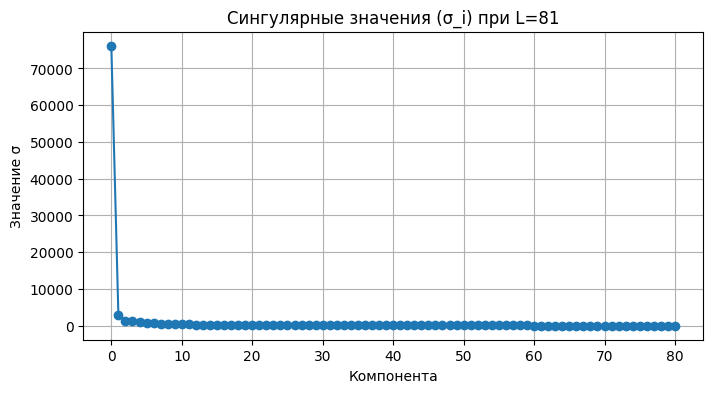

In [25]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

plt.figure(figsize=(8, 4))
plt.plot(Sigma, marker='o')
plt.title('Сингулярные значения (σ_i) при L=81')
plt.xlabel('Компонента')
plt.ylabel('Значение σ')
plt.grid(True)
plt.show()


In [26]:
rc1 = reconstruct_component(U, Sigma, VT, 0)
rc2 = reconstruct_component(U, Sigma, VT, 1)
rc3 = reconstruct_component(U, Sigma, VT, 2)
rc4 = reconstruct_component(U, Sigma, VT, 3)

rc_12 = rc1 + rc2
rc_1234 = rc1 + rc2 + rc3 + rc4


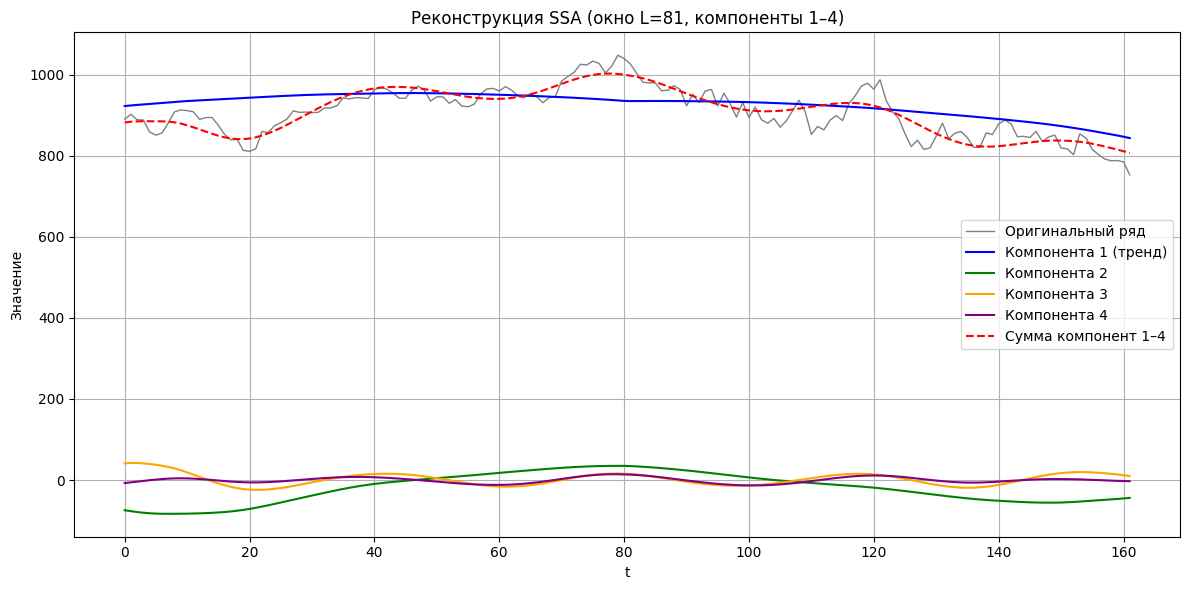

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Оригинальный ряд', color='gray', linewidth=1)
plt.plot(rc1, label='Компонента 1 (тренд)', color='blue')
plt.plot(rc2, label='Компонента 2', color='green')
plt.plot(rc3, label='Компонента 3', color='orange')
plt.plot(rc4, label='Компонента 4', color='purple')
plt.plot(rc_1234, label='Сумма компонент 1–4', color='red', linestyle='--')
plt.title('Реконструкция SSA (окно L=81, компоненты 1–4)')
plt.xlabel('t')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Выводы: SSA при L = 81

Размер матрицы Ганкеля: (81, 82)
Почти квадратная форма: хорошая для разложения, минимизирует искажения. Максимально раскрывает долгосрочные зависимости в структуре ряда.

**Матрица Ганкеля**

Диагонали выражены ярко и отчётливо — отражают протяжённые тенденции и повторяющиеся колебания.

Гладкие переходы — признак хорошей структуры для SVD.

**Сингулярные значения**

Ярко выраженный "скачок" от первой компоненты к остальным.

2–4 компоненты дают вклад — но в разы меньше.

Хвост из 70+ компонент отражает высокочастотный шум и нерегулярности.

**Компоненты 1–4:**

Компонента 1 (тренд):

Самая гладкая и "высокого уровня";

Отлично улавливает глобальную форму: рост — пик — падение.

Компоненты 2–4:

Имеют четко выраженные синусоидальные формы;

Их амплитуды невелики, но они добавляют реалистичности и "жизни" к общей структуре;

Хорошо улавливают сезонность и среднесрочные колебания.

Сумма компонент 1–4:

Даёт качественную реконструкцию оригинального ряда;

Убирает шум, сохраняя тренд и структуру.

In [28]:
import pandas as pd

# Данные
data = {
    "Окно L": [10, 20, 40, 81],
    "Что видно": [
        "Местный тренд, осцилляции невыражены",
        "Тренд + первые признаки сезонности",
        "Хорошая структура, стабильные волны",
        "Оптимальное разложение: тренд + цикл + шум"
    ]
}

# Таблица
summary_df = pd.DataFrame(data)
summary_df


,Окно L,Что видно
0,10,"Местный тренд, осцилляции невыражены"
1,20,Тренд + первые признаки сезонности
2,40,"Хорошая структура, стабильные волны"
3,81,Оптимальное разложение: тренд + цикл + шум


#Общие выводы по исследованию SSA

Основные наблюдения:

✅ L = 10: хорошо виден локальный тренд, но осцилляции не раскрываются;

✅ L = 20: появляются первые сезонные колебания, тренд всё ещё локален;

✅ L = 40: достигается устойчивая декомпозиция, осцилляции ясны;

✅ L = 81: наилучшее разложение — чётко отделяются тренд, циклы и шум.


Метод SSA позволяет эффективно выделять скрытые структуры в временных рядах:

При правильно выбранной длине окна он отделяет тренд, периодические компоненты и шум;

Особенно полезен при визуальном анализе, восстановлении сигнала и снижении влияния шума.

#Краткие рекомендации для продолжения исследования ряда Dow Jones

**1. Анализ остатка (residual)**

→ Вычесть реконструкцию (1–4 компоненты) из оригинального ряда и проанализировать остаток на шум/аномалии.

**2. Группировка компонент**

→ Объединять компоненты по парам (например, 2+3, 4+5) для выделения циклов разной частоты.

**3. Прогнозирование на основе SSA**

→ Построить SSA-форкаст по выбранным компонентам (например, тренд + осцилляции).

**4. Сравнение с другими методами**

→ Сравнить результат SSA с STL, ARIMA или Prophet по качеству разложения и интерпретируемости.
